<a href="https://colab.research.google.com/github/Archarlie2000/CSE450/blob/main/Module_7_v3_with_pic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

In [1]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 610 kB/s 


In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
import helper

In [3]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.spike_op = self.SpikeOperator.apply
  
  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_op((mem-self.threshold))  # call the Heaviside function
    reset = (spk * self.threshold).detach() # removes spike_op gradient from reset
    mem = self.beta * mem + input_ - reset # Eq (1)
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the Spike itself
  @staticmethod
  class SpikeOperator(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float() # Heaviside on the forward pass: Eq(2)
          ctx.save_for_backward(spk)  # store the spike for use in the backward pass
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (spk,) = ctx.saved_tensors  # retrieve the spike 
          grad = grad_output * spk # scale the gradient by the spike: 1/0
          return grad


lif1 = LeakySurrogate(beta=0.9)
lif1 = snn.Leaky(beta=0.9)

In [13]:
# Load data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_partial.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_classes_partial.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/test.zip
!unzip -q /content/test_partial.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip
!rm test_partial.zip

!echo "Data ready."

# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, layers 
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn.metrics import accuracy_score
training_dir = '/content/training/'


# Connect to drive
from google.colab import drive
drive.mount('/content/drive')


image_size = (100, 100)

Unzipping files...
replace test/04354.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test_partial/00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Merging training data...
mkdir: cannot create directory ‘/content/training’: File exists
mv: cannot move '/content/training1/00000' to '/content/training/00000': Directory not empty
mv: cannot move '/content/training1/00001' to '/content/training/00001': Directory not empty
mv: cannot move '/content/training1/00002' to '/content/training/00002': Directory not empty
mv: cannot move '/content/training1/00003' to '/content/training/00003': Directory not empty
mv: cannot move '/content/training1/00004' to '/content/training/00004': Directory not empty
mv: cannot move '/content/training1/00005' to '/content/training/00005': Directory not empty
mv: cannot move '/content/training1/00006' to '/content/training/00006': Directory not empty
mv: cannot move '/content/training1/00007' to '/content/training/00007': Directory not empty
mv: cannot move 

In [14]:
image_size = (100, 100)
# dataloader arguments
batch_size = 128

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Define a transform
transform = transforms.Compose([
            transforms.Resize((50, 50)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])


In [15]:
data_dir = '/content/training'

train_data = datasets.ImageFolder(data_dir,  transform = transform)  

spl1 = round(len(train_data) * 4 / 5)
spl2 = len(train_data) - round(len(train_data) * 4 / 5)

train_set, val_set = torch.utils.data.random_split(train_data, [spl1, spl2])

In [16]:


#Data Loading
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)
test_loader = torch.utils.data.DataLoader(train_set, batch_size=32)


In [17]:
num_inputs = 100 * 100
num_hidden = 1000
num_outputs = 43

# Temporal Dynamics
num_steps = 25
beta = 0.95


# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)

In [18]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [19]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 5e-4, betas=(0.9, 0.999))
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

spk_rec, mem_rec = net(data.view(batch_size, -1))

print(mem_rec.size())
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

RuntimeError: ignored

In [ ]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train = True)

# Train

In [12]:
num_epochs = 30
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

RuntimeError: ignored

If this was your first time training an SNN, then congratulations!

# 8. Results
## 8.1 Plot Training/Test Loss

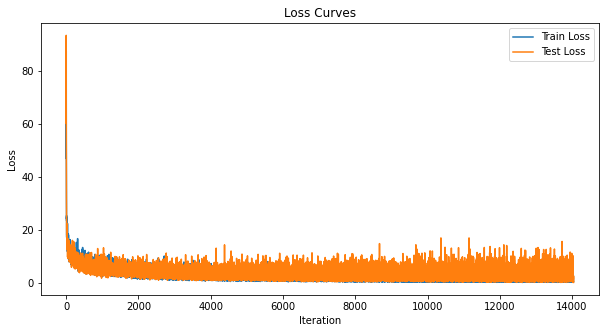

In [23]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

The loss curves are noisy because the losses are tracked at every iteration, rather than averaging across multiple iterations. 

## 8.2 Test Set Accuracy
This function iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

In [24]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 8761/10000
Test Set Accuracy: 87.61%
